# Speech Commands
In this Practical work you will be given voice commands recorded by devices such as assistants. The task is to recognize the voice command from the audio signal. The dataset is stored as waveforms, each one being a 1 second file containing one voice command. The first step will be to extract speech features, either Melfilterbanks or MFCC. Then you will train different type of classifiers to recognize the spoken voice command from the speech features. These classifiers are a Logistic Regression and a Neural Network.

### Replace the path in the shell below by the one that contains the dataset

In [1]:
import numpy as np
import spectral
import librosa
import IPython
import os
import scipy.io.wavfile as wav
import sklearn
from sklearn.neural_network import MLPClassifier
os.chdir('/home/ratnamogan/Documents/Speech_and_NLP/MVA_2018_SL/TD_#1/speech_commands_v0.01')
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(777)

These functions are just utilities that will help facilitate features extraction. Feel free to modify them if you need to, but it is not required.

In [2]:
def txt2list(filename):
    lines_list = []
    with open(filename, 'r') as txt:
        for line in txt:
            lines_list.append(line.rstrip('\n'))
    return lines_list

def transform_wavs(wavs_list, feature_func):
    features = []
    for wav in wavs_list:
        features.append(feature_func.transform(wav).flatten())
    return features

def pad(features):
    max_len = 0
    padded_features =[]
    for feat_file in features:
        max_len = max(max_len, feat_file.shape[0])
    for feat_file in features:
        pad_size = max_len - feat_file.shape[0]
        left_pad = pad_size / 2
        right_pad = pad_size - left_pad
        padded_features.append(np.pad(feat_file, ((left_pad, right_pad),), 'constant', constant_values=(0, 0)))
    return padded_features

Load the data. In this practical work, you are expected to train your models on the training set and evaluate them on the validation set. When you will get your final best model, report the results on the test set.

In [4]:
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

In [4]:
# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

Train files:3000
Valid files:1000
Test files:1000


The following cells create feature functions that have a .transform method that takes a waveform as input. You should not change the framerate parameter (the dataset is sampled at 16kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

In [5]:
framerate = 16000

# Mel-filterbanks function

In [7]:
melfbanks = spectral.Spectral(nfilt=20,
                    ncep=0,
                    do_dct=False,
                    lowerf=300,
                    upperf=3000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.035,
                    nfft=512,
                    compression='log',
                    do_deltas=False,
                    do_deltasdeltas=False)

# MFCC function

In [8]:
mfcc = spectral.Spectral(nfilt=40,
                    ncep=8,
                    do_dct=True,
                    lowerf=700,
                    upperf=3000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.020,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

# The following cell generates the features for train, valid and test from the waveforms

In [6]:
# Choose the feature function
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()

print "Time to output features: " + str(end-start)

NameError: name 'mfcc' is not defined

In [10]:
# Next cell trains a logistic regression on the speech features

In [11]:
#Logistic regression

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777)

start = time.time()
logreg.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

[LibLinear]Training time: 43.4992799759


# You can now evaluate it on the validation set

In [12]:
print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"

Accuracy on valid set 30.8%


In [13]:
neural_net = MLPClassifier(hidden_layer_sizes=(100,), validation_fraction = 0.2, early_stopping = False,
                                   verbose = True, random_state = 777, learning_rate='constant',
                                   learning_rate_init=0.01)

start = time.time()
neural_net.fit(train_feats, train_labels)
end = time.time()

print "Training time: " + str(end-start)

Iteration 1, loss = 8.57260395
Iteration 2, loss = 2.30985733
Iteration 3, loss = 2.27867508
Iteration 4, loss = 2.23977425
Iteration 5, loss = 2.13899006
Iteration 6, loss = 2.00991395
Iteration 7, loss = 1.87750806
Iteration 8, loss = 1.78766260
Iteration 9, loss = 1.70213252
Iteration 10, loss = 1.64838896
Iteration 11, loss = 1.58741420
Iteration 12, loss = 1.55820175
Iteration 13, loss = 1.53382113
Iteration 14, loss = 1.49715784
Iteration 15, loss = 1.47739541
Iteration 16, loss = 1.43821284
Iteration 17, loss = 1.40606602
Iteration 18, loss = 1.38419158
Iteration 19, loss = 1.39850697
Iteration 20, loss = 1.39916344
Iteration 21, loss = 1.32282678
Iteration 22, loss = 1.32841044
Iteration 23, loss = 1.34434855
Iteration 24, loss = 1.31605679
Iteration 25, loss = 1.27605889
Iteration 26, loss = 1.28270721
Iteration 27, loss = 1.25507356
Iteration 28, loss = 1.24661880
Iteration 29, loss = 1.22665303
Iteration 30, loss = 1.20479735
Iteration 31, loss = 1.17844277
Iteration 32, los

# Evaluate it on the valid set

In [14]:
print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"

Accuracy on valid set 38.3%


# Listen to a random waveform from the training set

In [15]:
random_idx = random.randint(0, len(valid_wavs))
random_wav = valid_wavs[random_idx]
IPython.display.Audio(random_wav, rate=16000)

# Visualize mel-filterbanks and MFCC

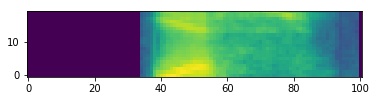

In [16]:
plt.imshow(melfbanks.transform(random_wav).transpose())
plt.gca().invert_yaxis()

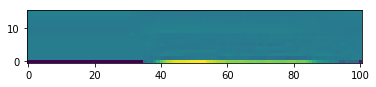

In [17]:
plt.imshow(mfcc.transform(random_wav).transpose())
plt.gca().invert_yaxis()

# See what your classifier has predicted

In [18]:
print label_set[neural_net.predict(valid_feats[random_idx][np.newaxis])[0]]

yes


# What you are expected to do in this TP
This notebook contains the different blocks that allow you to train speech commands recognizers. The results provided with the features and classifiers above are far from optimal.

You are expected to explore various ways to improve their performance. Here are the main things to try:
* The parameters of the speech features such as the min/max frequency or window size are poorly chosen, look inside the resources mentioned in the class to find the best parameters for mel-filterbanks and MFCC.
* The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one
* The neural net proposed is a shallow neural net, far from the best you can train. You should try bigger, deeper architectures, different types of regularization, activation functions, learning rate and so on
* A standard way of improving generalization is to do mean-variance normalization on your data set. This is done by computing the mean and variance of each feature dimension on the entire training set, and then use it to normalize train, valid and test set
* The dataset provides noises samples, either artificial (pink, white noise) or real (dishes, bike) in the folder _background_noise. You can try augmenting your dataset by adding noise to the waveforms before computing the features
* The model is only trained on 300 examples per class, if your hardware allows it, try training on more examples
* Feel free to also experiment with different classifiers

You should find the best model by comparing validation accuracies. After you find your best model, finally test it on the test set and print the result. Comment on the results (best model, best features, classes that are the most difficult to recognize). The grade will not depend on the performance of the final system, but on how you experimented, tried different ideas, and comment on them.

Write your comments in Markdown cells, and send the ipython notebook as your assignment. Good luck!

[Documentation for logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[Documentation for neural network](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

# Introduction and comments

In the following cells I will try to explore all the points described above. 
I can note a bug in the way the validation and the test files are computed.
Indeed, taking linearly the first examples in the valid list and test list will extract only examples for some specific speech commands. Hence using the provided code some commands will not be tested. In the following exploration, I will use the code as provided in order to obtain a score comparable with the one that as been computed as a benchmark.
Moreover, I will only use MFCC based features in the followings tests because we have seen in class that it performs better than  mel-filterbanks for a language such as the english where vocal tract contains most of the information needed for speech command recognition. I will not use end-to-end deep learning approach because it's the topic of the next class.

In order to run the whole code, one need to install the following librairies: keras+tensorflow, XGBoost, lightgbm 

# Determine adapted parameters for MFCC

In [8]:
##Grid search to determine the best parameters for Logistic Regression 
##Used extra link: http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
##As described in class a good parameters for the window size is between 0.10 and 0.40ms 
##We can see that in our dataset most of the commands that we are trying to detect are short with really short phonemes
##Hence low window size between 0.10 and 0.25 would be a good setting


windows_ex = [0.010,0.015,0.020,0.025]
low_freq_ex = [0,200,400,600]
high_freq_ex = [2000,3000,4000,5000,6000,7000]
n = 20
list_score =[]
for w in windows_ex:
    for lf_ex in low_freq_ex:
        for hf_ex in high_freq_ex:
            mfcc = spectral.Spectral(nfilt=n,
                                ncep=8,
                                do_dct=True,
                                lowerf=lf_ex,
                                upperf=hf_ex,
                                alpha=0.6,
                                fs=framerate,
                                frate=100,
                                wlen=w,
                                nfft=512,
                                compression='log',
                                do_deltas=True,
                                do_deltasdeltas=False)
            # Choose the feature function
            feature_function = mfcc

            start = time.time()
            train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
            valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
            test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
            end = time.time()

            print "Time to output features: " + str(end-start)
            #Logistic regression

            logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777)

            start = time.time()
            logreg.fit(train_feats, train_labels)
            end = time.time()

            print "Training time: " + str(end-start)

            print "Accuracy on valid set " + str(100*logreg.score(valid_feats, valid_labels)) + "%"

            neural_net = MLPClassifier(hidden_layer_sizes=(100,), validation_fraction = 0.2, early_stopping = True,
                               verbose = False, random_state = 777, learning_rate='constant',
                               learning_rate_init=0.01)

            start = time.time()
            neural_net.fit(train_feats, train_labels)
            end = time.time()

            print "Training time: " + str(end-start)
            print "Accuracy on valid set " + str(100*neural_net.score(valid_feats, valid_labels)) + "%"

            list_score.append([n,w,lf_ex,hf_ex,100*logreg.score(valid_feats, valid_labels),100*neural_net.score(valid_feats, valid_labels)])



Time to output features: 33.7085969448
[LibLinear]Training time: 45.6211628914
Accuracy on valid set 34.9%
Training time: 0.568686008453
Accuracy on valid set 28.0%
Time to output features: 33.186204195
[LibLinear]Training time: 46.8792290688
Accuracy on valid set 38.0%
Training time: 0.419902086258
Accuracy on valid set 25.8%
Time to output features: 33.581412077
[LibLinear]Training time: 41.6395390034
Accuracy on valid set 40.6%
Training time: 0.571078062057
Accuracy on valid set 17.0%
Time to output features: 34.0324659348
[LibLinear]Training time: 39.5622241497
Accuracy on valid set 43.9%
Training time: 0.497740030289
Accuracy on valid set 16.4%
Time to output features: 33.3309369087
[LibLinear]Training time: 43.1205470562
Accuracy on valid set 46.7%
Training time: 3.37910509109
Accuracy on valid set 59.1%
Time to output features: 34.0288619995
[LibLinear]Training time: 42.8684442043
Accuracy on valid set 48.4%
Training time: 2.09175181389
Accuracy on valid set 54.4%
Time to output

Time to output features: 33.2271108627
[LibLinear]Training time: 45.38610816
Accuracy on valid set 45.1%
Training time: 2.33100509644
Accuracy on valid set 39.9%
Time to output features: 33.6013548374
[LibLinear]Training time: 46.1939461231
Accuracy on valid set 47.7%
Training time: 0.396554946899
Accuracy on valid set 33.0%
Time to output features: 33.8819890022
[LibLinear]Training time: 43.1461520195
Accuracy on valid set 50.0%
Training time: 2.05023312569
Accuracy on valid set 49.4%
Time to output features: 33.8349740505
[LibLinear]Training time: 42.8787870407
Accuracy on valid set 51.9%
Training time: 3.5405819416
Accuracy on valid set 57.8%
Time to output features: 34.7003591061
[LibLinear]Training time: 45.5204491615
Accuracy on valid set 40.3%
Training time: 2.75130009651
Accuracy on valid set 44.8%
Time to output features: 33.7785217762
[LibLinear]Training time: 44.4349091053
Accuracy on valid set 44.3%
Training time: 0.416059017181
Accuracy on valid set 42.3%
Time to output fe

In [10]:
print('Nb of combinations tested ',len(list_score))

import numpy as np

table_outcome = np.array(list_score)

array_sort_by_outcome_logistic_reg = table_outcome[table_outcome[:,-2].argsort()]
array_sort_by_outcome_neural_network = table_outcome[table_outcome[:,-1].argsort()]

import pandas as pd

data_frame_sort_logistic_reg = pd.DataFrame(data=array_sort_by_outcome_logistic_reg,columns=['nfilt','wlen','lowfreq','highfreq','score log reg','score neural net'])
data_frame_sort_neural_net= pd.DataFrame(data=array_sort_by_outcome_neural_network,columns=['nfilt','wlen','lowfreq','highfreq','score log reg','score neural net'])

print(data_frame_sort_logistic_reg)
#print(data_frame_sort_neural_net)


('Nb of combinations tested ', 96)
    nfilt   wlen  lowfreq  highfreq  score log reg  score neural net
0    20.0  0.010    600.0    2000.0           27.0              37.4
1    20.0  0.025    600.0    2000.0           27.9              38.2
2    20.0  0.015    600.0    2000.0           28.7              34.0
3    20.0  0.020    600.0    2000.0           29.7              17.0
4    20.0  0.015    600.0    3000.0           30.9              14.2
5    20.0  0.010    400.0    2000.0           32.2              29.7
6    20.0  0.020    600.0    3000.0           32.7              28.8
7    20.0  0.010    600.0    3000.0           33.1              39.8
8    20.0  0.025    600.0    3000.0           33.2              26.3
9    20.0  0.025    400.0    2000.0           34.3              47.5
10   20.0  0.010    200.0    2000.0           34.5              35.8
11   20.0  0.015    400.0    2000.0           34.8              15.8
12   20.0  0.010      0.0    2000.0           34.9              28.0

# Conclusion on the test for choosing the parameters of MFCC
 
The best outcome with the logistic Regression only is given by wlen=0.025, lowf=0 and highf=6000.

The best outcome with the Neural network is given by wlen0.015,lowf=0 and highf=7000.

However, one not have to take this table as fair, this outcome is given by the algorithm for this specific validation set without any type of regularization or advanced technics (it also highly depends on the initialization because
we haven't done any legit statistics) this table only serves as an indicator to confirm what one can understand by himself.

Indeed what we can understand from that table and what we have seen in class that it's better to have really high
upperfreq about 7000 , really lowf about 0 and wlen of 0.020 to decompose well the phonemes that we are dealing with.

Default value for MFCC are given by lowerf=133.3333,upperf=6855.4976 and wlen=0.01 that is really to close to our statement

The parameters are really close to the one that I will keep. I have just set the wlen parameter a bit higher because of the specific words we are dealing with

# Setting the C parameters of the logistic Regression and try normalization:


The logistic regression can be regularized in different ways (by controlling the C parameter) and you can try to find the best one.

From the previous test. I will set the window to 0.2, the minfreq to 0 and maxfreq to 5000.

I will try the algorithm with and without mean-variance normalization.

In [11]:
from sklearn.preprocessing import StandardScaler

Normalizer = StandardScaler() #tool to normalize

mfcc = spectral.Spectral(nfilt=20,
                            ncep=8,
                            do_dct=True,
                            lowerf=0,
                            upperf=7000,
                            alpha=0.6,
                            fs=framerate,
                            frate=100,
                            wlen=0.020,
                            nfft=512,
                            compression='log',
                            do_deltas=True,
                            do_deltasdeltas=False)

C_value = [0.1,0.3,0.5,0.7,0.9,1,2,3,10,20]
feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
print "Time to output features: " + str(end-start)

normalized_features_train = Normalizer.fit_transform(train_feats)
normalized_features_val = Normalizer.transform(valid_feats)
normalized_features_test = Normalizer.transform(test_feats)


list_score_log_reg = []
for c in C_value:
    #Logistic regression

    logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777,C=c)

    start = time.time()
    logreg.fit(train_feats, train_labels)
    end = time.time()
    
    logreg_normalized = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777,C=c)
    logreg_normalized.fit(normalized_features_train, train_labels)
    list_score_log_reg.append([c,100*logreg.score(valid_feats, valid_labels),100*logreg_normalized.score(normalized_features_val, valid_labels)])



Time to output features: 33.7113890648
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]      C  score logreg  score logreg+norm
0  20.0          43.7               39.9
1  10.0          44.6               41.4
2   3.0          48.0               42.1
3   2.0          49.5               43.5
4   1.0          51.9               45.2
5   0.9          52.3               45.3
6   0.7          53.5               46.0
7   0.5          53.9               46.1
8   0.3          55.7               48.9
9   0.1          57.7               52.3


In [12]:
table_outcome_log_reg = np.array(list_score_log_reg)

array_sort_by_outcome_logistic_reg_reg = table_outcome_log_reg[table_outcome_log_reg[:,-1].argsort()]
import pandas as pd

data_frame_sort_logistic_reg_reg = pd.DataFrame(data=array_sort_by_outcome_logistic_reg_reg,columns=['C','score-logreg','score-logreg+norm'])

print(data_frame_sort_logistic_reg_reg)

      C  score-logreg  score-logreg+norm
0  20.0          43.7               39.9
1  10.0          44.6               41.4
2   3.0          48.0               42.1
3   2.0          49.5               43.5
4   1.0          51.9               45.2
5   0.9          52.3               45.3
6   0.7          53.5               46.0
7   0.5          53.9               46.1
8   0.3          55.7               48.9
9   0.1          57.7               52.3


# Conclusion on how to choose the C parameter for Logistic Regression and Normalization

As it can be seen, adding a penalty in the logistic regression allows to outperform the basic model.
Adding a penalty that constrain the model to be regular allows to get a score of 57.7 instead of the previous score
of 50.3. 

It's disappointing to observe that we get a final score lower using a standard normalization for the training and 
the validation set.  We only have obtained gains in the time spent for training process. Hence, during the next cells we will still compute the outcome with and without normalization.


# Using various Classifiers to improve the final accuracy

In [28]:
## Using More examples with logistic regression and various classifiers based on decision trees (with high performances)
## In this cell we will run various algorithms with the parameters that seems to be good from the previous tests
## We will also use normalizsklearnarnarnsklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

print('Go')
Normalizer = StandardScaler()

####Read Data##########################"
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 1000 #More exemples per class now : 10 000 total examples instead of 3000
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

framerate = 16000

mfcc = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=0,
                    upperf=7000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.020,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
print "Time to output features: " + str(end-start)

normalized_features_train = Normalizer.fit_transform(train_feats)
normalized_features_val = Normalizer.transform(valid_feats)
normalized_features_test = Normalizer.transform(test_feats)

###Outcome logreg#####
c = 0.1

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777,C=c)
logreg.fit(normalized_features_train, train_labels)
print('Score Logistic Regression with normalization on val set',100*logreg.score(normalized_features_val, valid_labels),'%')
print('Score Logistic Regression with normalization on test set',100*logreg.score(normalized_features_test, test_labels),'%')

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777,C=c)
logreg.fit(train_feats, train_labels)
print('Score Logistic Regression without normalization on val set',100*logreg.score(valid_feats, valid_labels),'%')
print('Score Logistic Regression without normalization on test set',100*logreg.score(test_feats, test_labels),'%')
###End Logreg####

###Outcome Random Forest##
rf_classifier = RandomForestClassifier(n_estimators=300)
rf_classifier.fit(normalized_features_train,train_labels) #No extra regularization, bagging is enough in general
print('Score RandomForestClassifier with normalization on val set',100*rf_classifier.score(normalized_features_val, valid_labels),'%')
print('Score RandomForestClassifier with normalization on test set',100*rf_classifier.score(normalized_features_test, test_labels),'%')

rf_classifier = RandomForestClassifier(n_estimators=300)
rf_classifier.fit(train_feats,train_labels) #No extra regularization, bagging is enough in general
print('Score RandomForestClassifier without normalization on val set',100*rf_classifier.score(valid_feats, valid_labels),'%')
print('Score RandomForestClassifier without normalization on test set',100*rf_classifier.score(test_feats, test_labels),'%')
###End Outcome Random Forest##

###Outcome XGBoost###
xgb_classifier = XGBClassifier(max_depth=6,n_estimators=300,reg_lambda=1) #with early stopping based on val set
xgb_classifier.fit(normalized_features_train,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='mlogloss',eval_set=[(normalized_features_train,train_labels),(normalized_features_val,valid_labels)])
print('Score XGBoost Classifier  with normalization on val set',100*xgb_classifier.score(normalized_features_val, valid_labels),'%')
print('Score XGBoost Classifier  with normalization on test set',100*xgb_classifier.score(normalized_features_test, test_labels),'%')

xgb_classifier = XGBClassifier(max_depth=6,n_estimators=300,reg_lambda=1)#with early stopping based on val set
xgb_classifier.fit(train_feats,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='mlogloss',eval_set=[(train_feats,train_labels),(valid_feats,valid_labels)])
print('Score XGBoost Classifier  without normalization on val set',100*xgb_classifier.score(valid_feats, valid_labels),'%')
print('Score XGBoost Classifier  without normalization on test set',100*xgb_classifier.score(test_feats, test_labels),'%')
###End outcome XGBoost###

###Outcome LGBM###
lgb_classifier = LGBMClassifier(max_depth=6,n_estimators=300,reg_lambda=1)#with early stopping based on val set
lgb_classifier.fit(normalized_features_train,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(normalized_features_train,train_labels),(normalized_features_val,valid_labels)])
print('Score LGBM Classifier  with normalization on val set',100*lgb_classifier.score(normalized_features_val, valid_labels),'%')
print('Score LGBM Classifier  with normalization on test set',100*lgb_classifier.score(normalized_features_test, test_labels),'%')

lgb_classifier = LGBMClassifier(max_depth=6,n_estimators=300,reg_lambda=1)#with early stopping based on val set
lgb_classifier.fit(train_feats,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(train_feats,train_labels),(valid_feats,valid_labels)])
print('Score LGBM Classifier  without normalization on val set',100*lgb_classifier.score(valid_feats, valid_labels),'%')
print('Score LGBM Classifier  without normalization on test set',100*lgb_classifier.score(test_feats, test_labels),'%')
###End LGBM####


Go
Train files:10000
Valid files:1000
Test files:1000
Time to output features: 78.8006851673
[LibLinear]('Score Logistic Regression with normalization on val set', 57.099999999999994, '%')
('Score Logistic Regression with normalization on test set', 52.0, '%')
[LibLinear]('Score Logistic Regression without normalization on val set', 60.5, '%')
('Score Logistic Regression without normalization on test set', 55.600000000000009, '%')
('Score RandomForestClassifier with normalization on val set', 80.100000000000009, '%')
('Score RandomForestClassifier with normalization on test set', 74.900000000000006, '%')
('Score RandomForestClassifier without normalization on val set', 80.0, '%')
('Score RandomForestClassifier without normalization on test set', 74.700000000000003, '%')
('Score XGBoost Classifier  with normalization on val set', 82.299999999999997, '%')
('Score XGBoost Classifier  with normalization on test set', 77.0, '%')
('Score XGBoost Classifier  without normalization on val set',

# Conclusion on using various classifiers for the command recognition task

Here  I present a summary table of the outcome that I have obtained using various classifiers for a given set of parameters (with and without normalization) on the command recognition task. 10 000 training samples and 1000 validation and test samples have been used for this task.

One have to note that test score gives a fair outcome, validation outcome is biaised because validation set information have been used for early stopping and for setting the MFCC/Logistic Regression parameters. 

Here are the outcome without normalization:

|                 |   Score on validation       |        Score on test    |
|--------------|----------------|-----------------|
| Logistic Regression  |     60.5   |       55.6  |
| Random Forest  |     80.0   |      74.7  |
| XGBoost  |     81.2  |      76.3  |
| LGBM  |     81.2  |      76.2  |

Here are the outcome with normalization

|                 |   Score on validation       |        Score on test    |
|--------------|----------------|-----------------|
| Logistic Regression  |     57.1   |       52.0  |
| Random Forest  |    80.1   |      74.9  |
| XGBoost  |     82.3  |      77.0  |
| LGBM  |     82.4  |      76.3  |

As we can see the complex binary tree based ensemble algorithms performs fairly well and allows to have about 75% accuracy on the test dataset. Normalization doesn't play a role in binary tree based algorithms but fasten a bit the logistic regression.


Automatically created module for IPython interactive environment
Go
Train files:10000
Valid files:1000
Test files:1000
Time to output features: 79.970690012
Computing XGB
End fitting XGB
('Score XGBoost Classifier  without normalization on val set', 81.200000000000003, '%')
('Score XGBoost Classifier  without normalization on test set', 76.5, '%')
Confusion matrix, without normalization
[[176   1   5   3   3  16  13  17  15   2]
 [  1 210   2   6   8  11   1   1  12   4]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  4   7   0   2   1 128   0   1  17   6]
 [  1   0   0   3   3   2  59   2   4   7]
 [  9   0   0   6   2   6  20 192   1  10]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


/home/ratnamogan/anaconda3/envs/TD_1/lib/python2.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in divide


Normalized confusion matrix
[[ 0.7   0.    0.02  0.01  0.01  0.06  0.05  0.07  0.06  0.01]
 [ 0.    0.82  0.01  0.02  0.03  0.04  0.    0.    0.05  0.02]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [ 0.02  0.04  0.    0.01  0.01  0.77  0.    0.01  0.1   0.04]
 [ 0.01  0.    0.    0.04  0.04  0.02  0.73  0.02  0.05  0.09]
 [ 0.04  0.    0.    0.02  0.01  0.02  0.08  0.78  0.    0.04]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]
 [  nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]]


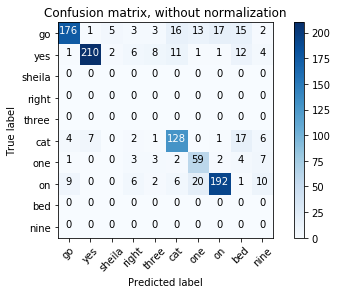

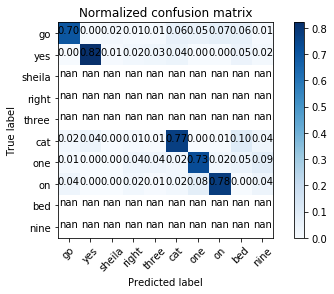

In [ ]:
#One can observe the confusion matrix in order to observe where the errors has been made and what commands are confusing

print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

print('Go')
Normalizer = StandardScaler()

####Read Data##########################"
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 1000 #More exemples per class now : 10 000 total examples instead of 3000
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

framerate = 16000

mfcc = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=0,
                    upperf=7000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.020,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
print "Time to output features: " + str(end-start)

###########################################################################################

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Compute XGB###  
print 'Computing XGB'
xgb_classifier = XGBClassifier(max_depth=6,n_estimators=300,reg_lambda=1)#with early stopping based on val set
xgb_classifier.fit(train_feats,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='mlogloss',eval_set=[(train_feats,train_labels),(valid_feats,valid_labels)])
print 'End fitting XGB'

print('Score XGBoost Classifier  without normalization on val set',100*xgb_classifier.score(valid_feats, valid_labels),'%')
print('Score XGBoost Classifier  without normalization on test set',100*xgb_classifier.score(test_feats, test_labels),'%')
###End outcome XGBoost###
y_pred = xgb_classifier.predict(test_feats)

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_set,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_set, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Confusion Matrix

From the confusion matrix that I have plot, it can be seen first that only 5 commands are in the test set as detailed in the introduction.
The outcome seems quite good, the most confusing commands are  naturally "one" and "on" but also "cat"/"bed" and "go"/"on". 
This kind of outcome shows that the outcome can still being improved.

# Data Augmentation

In this part the goal is to augment the training set by adding some background noise to our original clean training set.

For this part I will use less training samples than on the previous test because my computer couldn't deal with more than 100k examples. I have used 3000 training samples.   

In [3]:
##Data augmentation with noise 

## Using More examples with logistic regression and various classifiers based on decision trees (with high performances)
## In this cell we will run various algorithms with the parameters that seems to be good from the previous tests
## We will also use normalizsklearnarnarnsklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np

print('Go')
Normalizer = StandardScaler()

####Read Data##########################"
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 300 #3000 original examples
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

noise_wavs= []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        for filename in files:
            if not filename.endswith('.wav'):
                continue
            full_name = os.path.join(root.lstrip('./'), filename)
            fs, waveform = wav.read(full_name)
            noise_wavs.append(waveform)
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
            

def Dataaugmentation(data_wav,noise_wav,nb_of_examples=10,i_noise=0):
    if i_noise==0:
        list_new_wavs = [data_wav] #keep prev
        nb_ex = nb_of_examples-1
    else:
        list_new_wavs = []
        nb_ex = nb_of_examples
    
    NoiseStartingPoints=np.random.randint(low=0,high= len(noise_wav)-1,size=nb_ex)

    for i_starting_point in NoiseStartingPoints:
        nb_start = i_starting_point
        nb_end = i_starting_point+len(data_wav)
        if nb_end>len(noise_wav):
            new_wav = data_wav + noise_wav[-len(data_wav):]
        else:
            new_wav = data_wav + noise_wav[i_starting_point:nb_end]
        list_new_wavs.append(new_wav)
    return list_new_wavs

new_train_wavs = []
new_train_labels = []
for i_train_wav,i_train_label in zip(train_wavs,train_labels):
    i_noise_ind = 0
    for i_noise_wav in noise_wavs:
        new_train_wavs = new_train_wavs + Dataaugmentation(i_train_wav,i_noise_wav,nb_of_examples=2,i_noise=i_noise_ind) #only double the training dataset because of the lack of memory
        new_train_labels= new_train_labels + list(2*[i_train_label])
        i_noise_ind= 1

train_wavs = new_train_wavs
train_labels = new_train_labels


print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

Go


/home/ratnamogan/anaconda3/envs/TD_1/lib/python2.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Train files:36000
Valid files:1000
Test files:1000


In [24]:
print 'Orignal wav'

ListenTOWav = train_wavs[0]
IPython.display.Audio(ListenTOWav, rate=16000)


Orignal wav


In [25]:
print 'Noisy wav'

ListenTOWav = train_wavs[1]
IPython.display.Audio(ListenTOWav, rate=16000)

Noisy wav


In [26]:
print 'Noisy wav'

ListenTOWav = train_wavs[2]
IPython.display.Audio(ListenTOWav, rate=16000)

Noisy wav


In [4]:
framerate = 16000

mfcc = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=0,
                    upperf=7000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.020,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
print "Time to output features: " + str(end-start)


Time to output features: 260.488820076


In [5]:
#I will use LGBM because it's way faster than XGBoost 

from lightgbm import LGBMClassifier
import sklearn

print('Computing LGBM Classifier')
lgb_classifier = LGBMClassifier(max_depth=6,n_estimators=300,reg_lambda=1)#with early stopping based on val set
lgb_classifier.fit(train_feats,train_labels,verbose=False,early_stopping_rounds=30,eval_metric='multi_logloss',eval_set=[(train_feats,train_labels),(valid_feats,valid_labels)])
print('Score LGBM Classifier  without normalization on val set',100*lgb_classifier.score(valid_feats, valid_labels),'%')
print('Score LGBM Classifier  without normalization on test set',100*lgb_classifier.score(test_feats, test_labels),'%')
###End LGBM####

# Use Logistic Regression to compare with the model with only 3000 examples
c = 0.1

logreg = sklearn.linear_model.LogisticRegression(verbose=1, tol=1e-3, random_state=777,C=c)
logreg.fit(train_feats, train_labels)
print('Score Logistic Regression without normalization on val set',100*logreg.score(valid_feats, valid_labels),'%')
print('Score Logistic Regression without normalization on test set',100*logreg.score(test_feats, test_labels),'%')

Computing LGBM Classifier
('Score LGBM Classifier  without normalization on val set', 73.299999999999997, '%')
('Score LGBM Classifier  without normalization on test set', 71.299999999999997, '%')
[LibLinear]('Score Logistic Regression without normalization on val set', 51.899999999999999, '%')
('Score Logistic Regression without normalization on test set', 51.399999999999999, '%')


# Conclusion on Data Augmentation

I can remind the score for Logistic Regression using 3000 raw training examples, I have obtained a score of 57.7% precision on the validation set.

Using 3000 raw training examples and data augmentation (x12 = 36 000 training samples) using the background noise samples I have obtained a score of 51.90%. My score has decreased. This can be explained by the fact that I have choosen the parameters for C and for MFCC in order to match the logistic regression with raw data so it helps it to have a great score. The second explanation can be given by the fact that in the validation set we have just clean samples without background noise. Hence adding noise doesn't help in this test but in the general real case it could help because in the real world samples are really noisy.


# Deep Neural Network for the speech recognition task with MFCC features

In this part I will create a legit Deep Neural Network architecture that will take MFCC features as input and output the probability to belong to each class.

I will use keras with tensorflow backend in order to compute the neural network in few lines.
I tried several architectures. In the next cells, I'm presenting the one that has provided the best outcome.

I will not use Data augmentation in this part because it doesn't seems to help to improve the final outcome. I will use normalized data because it helps for the convergence of a DNN.



In [6]:
##Read Data
print(__doc__)

from sklearn.preprocessing import StandardScaler

Normalizer = StandardScaler()

####Read Data##########################"
## Loading data
label_set = ['go', 'yes', 'sheila', 'right', 'three', 'cat', 'one', 'on', 'bed', 'nine']
nb_ex_per_class = 1000 #More exemples per class now : 10 000 total examples instead of 3000
# Valid set
valid_list = txt2list('validation_list.txt')
# Test set
test_list = txt2list('testing_list.txt')

# Iterate over files
train_wavs = []
train_labels = []

valid_wavs = []
valid_labels = []

test_wavs = []
test_labels = []

for root, dirs, files in os.walk("."):
    if root == './_background_noise_':
        continue
    for filename in files:
        if not filename.endswith('.wav'):
            continue
        command = root.lstrip('./')
        if command not in label_set:
            continue
        else:
            label = label_set.index(command)
        full_name = os.path.join(root.lstrip('./'), filename)
        fs, waveform = wav.read(full_name)
        if full_name in valid_list and len(valid_labels) < 1000:
            valid_wavs.append(waveform)
            valid_labels.append(label)
        elif full_name in test_list and len(test_labels) < 1000:
            test_wavs.append(waveform)
            test_labels.append(label)
        elif train_labels.count(label) < nb_ex_per_class:
            train_wavs.append(waveform)
            train_labels.append(label)
# Print data statistics

print "Train files:" + str(len(train_wavs))
print "Valid files:" + str(len(valid_wavs))
print "Test files:" + str(len(test_wavs))

framerate = 16000

mfcc = spectral.Spectral(nfilt=20,
                    ncep=8,
                    do_dct=True,
                    lowerf=0,
                    upperf=7000,
                    alpha=0.6,
                    fs=framerate,
                    frate=100,
                    wlen=0.020,
                    nfft=512,
                    compression='log',
                    do_deltas=True,
                    do_deltasdeltas=False)

feature_function = mfcc

start = time.time()
train_feats = np.asarray(pad(transform_wavs(train_wavs, feature_function)))
valid_feats = np.asarray(pad(transform_wavs(valid_wavs, feature_function)))
test_feats = np.asarray(pad(transform_wavs(test_wavs, feature_function)))
end = time.time()
print "Time to output features: " + str(end-start)

print "Normalizing data"

normalized_features_train = Normalizer.fit_transform(train_feats)
normalized_features_val = Normalizer.transform(valid_feats)
normalized_features_test = Normalizer.transform(test_feats)

Automatically created module for IPython interactive environment
Train files:10000
Valid files:1000
Test files:1000
Time to output features: 81.0798778534
Normalizing data


In [12]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Convolution1D,MaxPooling1D,Flatten,BatchNormalization,Dropout
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

nb_of_categories = 10


normalized_features_train = normalized_features_train.reshape((normalized_features_train.shape[0],-1,1))
normalized_features_val = normalized_features_val.reshape((normalized_features_val.shape[0],-1,1))
normalized_features_test = normalized_features_test.reshape((normalized_features_test.shape[0],-1,1))

print('Compute categarical features')
all_labels = train_labels + valid_labels+ test_labels #do that because there is no all examples on the test and valid sets
all_labels_cat = to_categorical(all_labels,nb_of_categories)

train_labels_cat = all_labels_cat[:len(train_labels)]
valid_labels_cat = all_labels_cat[len(train_labels):len(train_labels)+len(valid_labels)]
test_labels_cat = all_labels_cat[-len(test_labels):]

mcp = ModelCheckpoint('weights.best.hdf5', monitor="val_acc",
                      save_best_only=True, save_weights_only=False)

model = Sequential()

model.add(Convolution1D(50,5,input_shape=(normalized_features_train.shape[1],1,)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution1D(20,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))
model.add(Convolution1D(40,4))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution1D(20,3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(nb_of_categories,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc'])


history= model.fit(normalized_features_train,train_labels_cat,validation_data=(normalized_features_val,valid_labels_cat),epochs=15,batch_size=32,callbacks=[mcp])

model = keras.models.load_model('weights.best.hdf5')

print('DNN network score',model.evaluate(normalized_features_test, test_labels_cat))



Compute categarical features
Train on 10000 samples, validate on 1000 samples
Epoch 1/15
10000/10000 [==============================] - 81s 8ms/step - loss: 1.5799 - acc: 0.4985 - val_loss: 1.2104 - val_acc: 0.6130
Epoch 2/15
10000/10000 [==============================] - 80s 8ms/step - loss: 0.9997 - acc: 0.6914 - val_loss: 1.0203 - val_acc: 0.6810
Epoch 3/15
10000/10000 [==============================] - 79s 8ms/step - loss: 0.7931 - acc: 0.7536 - val_loss: 0.8126 - val_acc: 0.7540
Epoch 4/15
10000/10000 [==============================] - 77s 8ms/step - loss: 0.6725 - acc: 0.7899 - val_loss: 0.8092 - val_acc: 0.7480
Epoch 5/15
10000/10000 [==============================] - 77s 8ms/step - loss: 0.5875 - acc: 0.8159 - val_loss: 0.6753 - val_acc: 0.7960
Epoch 6/15
10000/10000 [==============================] - 76s 8ms/step - loss: 0.5294 - acc: 0.8352 - val_loss: 0.7663 - val_acc: 0.7530
Epoch 7/15
10000/10000 [==============================] - 77s 8ms/step - loss: 0.4761 - acc: 0.8472 

# Conclusion on using Deep Neural Network

As it can be seen using 10 000 samples instead of the original 3 000 training samples and a particular architecture of Deep Neural Network has allowed to obtain a final accuracy score of 77.5% that is actually the best outcome obtained during our whole exploration. 

Improving the architecture of the Deep Neural network and doing classical regularization methods (bagging, mixture of experts ...) should allow to get better outcomes. 

# General Conclusion

In this first TD of "the Algorithms for speech and natural language processing", it has been asked to explore various ideas in order to obtain a good score on a speech command recognition task.

By combining a greedy search and what have been seen in class, I have improved how MFCC parameters are setted.

I also improved the basic logistic regression used by improving how the C parameter for regularization was choosen. 

Then I have used more data in the training set and I have obtained good outcomes with boosting algorithms. 

Using some background noise files I have created a function that allows to apply a  data augmentation. However because dealing with quite big dataset is really costly computationally and because using this data augmentation technics isn't improving our final outcome with Logistic Regression it hasn't been used that much.

Finally, I've created a deep neural network architecture to deal with the speech command recognition task (taking as input MFCC features). Using 10000 examples and a specific architecture I've obtained a final score of 77,5% accuracy on the test set that is the best score that I've obtained. 


Pirashanth RATNAMOGAN - Master MVA 2017-2018